In [1]:
import os
from datasets import load_dataset
from PIL import Image
import pandas as pd
import torch

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [3]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows
pd.set_option('display.max_colwidth', None) # Show full content of each column (no truncation)
pd.set_option('display.width', None)

In [4]:
dataset = load_dataset("ahmedheakl/arocrbench_patsocr",split="train")

In [5]:
dataset

Dataset({
    features: ['image', 'answer', 'source'],
    num_rows: 500
})

In [6]:
results = []
for sample in dataset:
    image = sample["image"]  # Already a PIL Image object
    if image.mode != "RGB":
        image = image.convert("RGB")
    ground_truth = sample["answer"]
    results.append({
        "image": image,
        "ground_truth": ground_truth,
        "qari": None,
        
    })
print(f"Initialized results with {len(results)} samples.")

Initialized results with 500 samples.


## Qwenvl2.5 3B 

In [7]:
import torch 
torch.cuda.empty_cache()

In [8]:
from transformers import AutoProcessor, AutoModelForImageTextToText

processor = AutoProcessor.from_pretrained("NAMAA-Space/Qari-OCR-0.1-VL-2B-Instruct",use_fast=True)

model = AutoModelForImageTextToText.from_pretrained("NAMAA-Space/Qari-OCR-0.1-VL-2B-Instruct",torch_dtype="auto",device_map="cuda:0")

In [9]:
from PIL import Image 
import requests

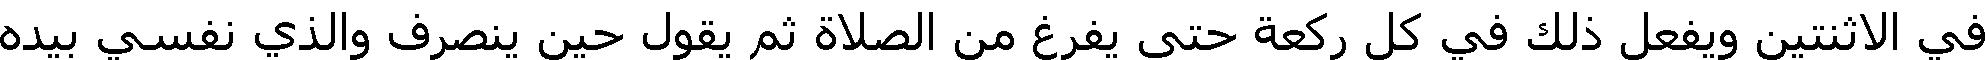

In [10]:
image = dataset[2]['image']
image

In [11]:
dataset[2]['answer']

'في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده\n'

In [13]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
            },
            {
                "type": "text",
                "text": "Below is the image of one page of a document, as well as some raw textual content that was previously extracted for it. Just return the plain text representation of this document as if you were reading it naturally. Do not hallucinate"
            }
        ]
    }
]

text_prompt = processor.apply_chat_template(messages, add_generation_prompt=True)



In [14]:
def qwen_extract_ocr(text_prompt,image):
    
    inputs = processor(
        text = [text_prompt],
        images = [image],
        padding = True,
        return_tensors = "pt"
    )

    inputs = inputs.to("cuda:0")

    output_ids = model.generate(**inputs, max_new_tokens=1024)

    generated_ids = [
        output_ids[len(input_ids) :]
        for input_ids, output_ids in zip(inputs.input_ids, output_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
    )
    return output_text


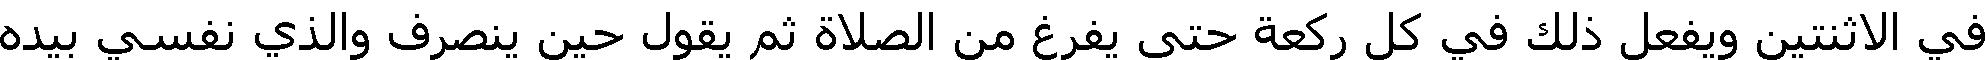

In [15]:
image = dataset[2]['image']
image

In [16]:
qwen_extract_ocr(text_prompt,image=dataset[2]['image'])


['في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده ']

In [17]:

for i, sample in enumerate(results):
    torch.cuda.empty_cache()
    image = sample['image']
    text_result = " ".join(qwen_extract_ocr(text_prompt,image=image))
    print(text_result)
    print("*****"*40)
    results[i]['qari'] = text_result

كان ثم ثالن يسميهم أبو رجاء فنسي موفه ثم خمر بن الخطاب الرابع وكان النيي على الله عليه 
********************************************************************************************************************************************************************************************************
معي صبرا قال لا تؤاخذيي بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب
********************************************************************************************************************************************************************************************************
في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده 
********************************************************************************************************************************************************************************************************
 صلى الله عليه وسلم خرج حين زاغت الشمس فصلى الظهر فقام على المنبر فذكر الساعة فذكر أن
****************************************************

In [19]:
import re

def remove_diacritics(text):
    diacritics = [
        '\u0617', '\u0618', '\u0619', '\u061A',  # Small high signs
        '\u064B', '\u064C', '\u064D', '\u064E', '\u064F', '\u0650',  # Tanween and basic diacritics
        '\u0651', '\u0652', '\u0653', '\u0654', '\u0655', '\u0656',  # Shadda, sukun, etc.
        '\u0657', '\u0658', '\u0659', '\u065A', '\u065B', '\u065C', 
        '\u065D', '\u065E', '\u065F', '\u0670'   # Additional Arabic diacritics
    ]
    pattern = '[' + ''.join(diacritics) + ']'
    return re.sub(pattern, '', text)
def remove_english_letters(text):
    # Regex pattern to match English letters (a-z and A-Z)
    pattern = r'[a-zA-Z]'
    # Replace English letters with an empty string
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [20]:
def clean_text(text):
    # Replace all tabs and multiple newlines with a single space
    cleaned = re.sub(r'[\n\t]+', ' ', text)
    # Replace multiple spaces with a single space
    cleaned = re.sub(r'\s+', ' ', cleaned)
    # Strip leading/trailing whitespace
    cleaned = cleaned.strip()
    return cleaned

In [36]:
df = pd.DataFrame(results)
df.head()

image  \
0   <PIL.Image.Image image mode=RGB size=1464x77 at 0x79EB3C1570D0>   
1   <PIL.Image.Image image mode=RGB size=1187x75 at 0x79EB340777D0>   
2   <PIL.Image.Image image mode=RGB size=1985x60 at 0x79EC045DE5D0>   
3  <PIL.Image.Image image mode=RGB size=1242x105 at 0x79EB3C594F50>   
4   <PIL.Image.Image image mode=RGB size=1552x57 at 0x79EB3C5BA5D0>   

                                                                                  ground_truth  \
0     فلان ثم فلان يسميهم أبو رجاء فنسي عوف ثم عمر بن الخطاب الرابع وكان النبي صلى الله عليه\n   
1        معي صبرا قال لا تؤاخذني بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب\n   
2      في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده\n   
3       صلى الله عليه وسلم خرج حين زاغت الشمس فصلى الظهر فقام على المنبر فذكر الساعة فذكر أن\n   
4  ليتني فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم\n   

                                                                                           qari  
0       كان ثم ثالن يسميهم أبو رجاء فنسي موفه ثم خمر بن الخطاب الرابع وكان النيي على الله عليه   
1           معي صبرا قال لا تؤاخذيي بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب  
2        في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده   
3          صلى الله عليه وسلم خرج حين زاغت الشمس فصلى الظهر فقام على المنبر فذكر الساعة فذكر أن  
4  lientsي فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم

In [37]:
df['ground_truth'] = df['ground_truth'].apply(remove_english_letters).apply(clean_text)
df['qari'] = df['qari'].apply(remove_english_letters).apply(clean_text)

In [38]:

df['ground_truth_t'] = df["ground_truth"].apply(remove_diacritics)
df['qari_t'] = df["qari"].apply(remove_diacritics)


In [39]:
df.head()

image  \
0   <PIL.Image.Image image mode=RGB size=1464x77 at 0x79EB3C1570D0>   
1   <PIL.Image.Image image mode=RGB size=1187x75 at 0x79EB340777D0>   
2   <PIL.Image.Image image mode=RGB size=1985x60 at 0x79EC045DE5D0>   
3  <PIL.Image.Image image mode=RGB size=1242x105 at 0x79EB3C594F50>   
4   <PIL.Image.Image image mode=RGB size=1552x57 at 0x79EB3C5BA5D0>   

                                                                                ground_truth  \
0     فلان ثم فلان يسميهم أبو رجاء فنسي عوف ثم عمر بن الخطاب الرابع وكان النبي صلى الله عليه   
1        معي صبرا قال لا تؤاخذني بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب   
2      في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده   
3       صلى الله عليه وسلم خرج حين زاغت الشمس فصلى الظهر فقام على المنبر فذكر الساعة فذكر أن   
4  ليتني فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم   

                                                                                     qari  \
0  كان ثم ثالن يسميهم أبو رجاء فنسي موفه ثم خمر بن الخطاب الرابع وكان النيي على الله عليه   
1     معي صبرا قال لا تؤاخذيي بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب   
2   في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده   
3    صلى الله عليه وسلم خرج حين زاغت الشمس فصلى الظهر فقام على المنبر فذكر الساعة فذكر أن   
4   ي فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم   

                                                                              ground_truth_t  \
0     فلان ثم فلان يسميهم أبو رجاء فنسي عوف ثم عمر بن الخطاب الرابع وكان النبي صلى الله عليه   
1        معي صبرا قال لا تؤاخذني بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب   
2      في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده   
3       صلى الله عليه وسلم خرج حين زاغت الشمس فصلى الظهر فقام على المنبر فذكر الساعة فذكر أن   
4  ليتني فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم   

                                                                                   qari_t  
0  كان ثم ثالن يسميهم أبو رجاء فنسي موفه ثم خمر بن الخطاب الرابع وكان النيي على الله عليه  
1     معي صبرا قال لا تؤاخذيي بما نسيت فكانت الأولى من موسى نسيانا فانطلقا فإذا غلام يلعب  
2   في الاثنتين ويفعل ذلك في كل ركعة حتى يفرغ من الصلاة ثم يقول حين ينصرف والذي نفسي بيده  
3    صلى الله عليه وسلم خرج حين زاغت الشمس فصلى الظهر فقام على المنبر فذكر الساعة فذكر أن  
4   ي فيها جذع ليتني أكون حيا إذ يخرجك قومك فقال رسول الله صلى الله عليه وسلم أو مخرجي هم

In [40]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qari"]:
    wer_score = wer(df["ground_truth"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qari - WER: 2.25, CER: 2.21


In [41]:
from jiwer import wer, cer 

# for model in ["tesseract","easyocr"]:
for model in ["qari_t"]:
    wer_score = wer(df["ground_truth_t"].tolist(), df[model].tolist())
    cer_score = cer(df["ground_truth_t"].tolist(), df[model].tolist())
    print(f"{model} - WER: {wer_score:.2f}, CER: {cer_score:.2f}")

qari_t - WER: 2.24, CER: 2.16


In [42]:
df.to_csv("khattat_dl_pastocr_namma_result.csv")

: 